In [1]:
import numpy as np
import pandas as pd

rng = np.random.default_rng(42)

VENDORS = ["MF TRADER", "Alpha Supplies", "PakTech", "Vision Systems", "Prime Traders"]
CITIES = ["Karachi", "Lahore", "Islamabad"]
CATEGORIES = {
    "HDP5000e Ribbon": "Ribbon",
    "Printer Cleaning Kit": "Accessories",
    "ID Card PVC Pack": "Accessories",
    "Printer Service Visit": "Service",
    "UHF Long Range Tag": "Accessories",
    "PolyGuard Lamination": "Accessories",
}
ITEMS = list(CATEGORIES.keys())

def make_base_price(vendor, item):
    base = {
        "HDP5000e Ribbon": 24000,
        "Printer Cleaning Kit": 3500,
        "ID Card PVC Pack": 5000,
        "Printer Service Visit": 8000,
        "UHF Long Range Tag": 200,
        "PolyGuard Lamination": 12000,
    }[item]
    # vendor variation
    vendor_factor = {
        "MF TRADER": 0.95,
        "Alpha Supplies": 1.00,
        "PakTech": 1.03,
        "Vision Systems": 1.06,
        "Prime Traders": 0.98,
    }[vendor]
    return base * vendor_factor

def generate_dataset(n_docs=600, anomaly_rate=0.08):
    rows = []
    start = pd.Timestamp("2025-01-01")
    for doc_i in range(n_docs):
        doc_id = f"DOC-{doc_i:05d}"
        doc_date = start + pd.to_timedelta(int(rng.integers(0, 365)), unit="D")
        vendor = rng.choice(VENDORS)
        city = rng.choice(CITIES)
        payment_terms_days = int(rng.choice([0, 15, 30, 45]))

        # 1–4 line items per doc
        n_lines = int(rng.integers(1, 5))
        for _ in range(n_lines):
            item = rng.choice(ITEMS)
            category = CATEGORIES[item]
            qty = int(rng.choice([1, 2, 3, 5, 10, 20, 50]))
            base_price = make_base_price(vendor, item)
            # normal noise
            unit_price = float(max(1, rng.normal(base_price, base_price * 0.03)))

            gst_rate = float(rng.choice([0.0, 0.18], p=[0.25, 0.75]))
            subtotal = qty * unit_price
            gst_amount = subtotal * gst_rate
            total = subtotal + gst_amount

            rows.append({
                "doc_id": doc_id,
                "doc_date": doc_date.date().isoformat(),
                "vendor": vendor,
                "item": item,
                "category": category,
                "qty": qty,
                "unit_price": round(unit_price, 2),
                "subtotal": round(subtotal, 2),
                "gst_rate": gst_rate,
                "gst_amount": round(gst_amount, 2),
                "total": round(total, 2),
                "payment_terms_days": payment_terms_days,
                "city": city,
                "is_duplicate": 0,
                "is_anomaly": 0,
                "anomaly_type": "normal",
            })

    df = pd.DataFrame(rows)

    # Inject anomalies
    n_anom = int(len(df) * anomaly_rate)
    idx = rng.choice(df.index, size=n_anom, replace=False)

    anomaly_types = ["overprice", "gst_mismatch", "total_mismatch", "qty_spike", "duplicate"]
    for i in idx:
        t = rng.choice(anomaly_types, p=[0.35, 0.2, 0.2, 0.15, 0.1])
        df.loc[i, "is_anomaly"] = 1
        df.loc[i, "anomaly_type"] = t

        if t == "overprice":
            df.loc[i, "unit_price"] = round(df.loc[i, "unit_price"] * float(rng.uniform(1.35, 2.2)), 2)

        elif t == "qty_spike":
            df.loc[i, "qty"] = int(df.loc[i, "qty"] * int(rng.choice([5, 10])))

        # recompute subtotal/gst/total correctly first
        df.loc[i, "subtotal"] = round(df.loc[i, "qty"] * df.loc[i, "unit_price"], 2)
        df.loc[i, "gst_amount"] = round(df.loc[i, "subtotal"] * df.loc[i, "gst_rate"], 2)
        df.loc[i, "total"] = round(df.loc[i, "subtotal"] + df.loc[i, "gst_amount"], 2)

        if t == "gst_mismatch":
            df.loc[i, "gst_amount"] = round(df.loc[i, "gst_amount"] * float(rng.uniform(0.2, 0.8)), 2)
            df.loc[i, "total"] = round(df.loc[i, "subtotal"] + df.loc[i, "gst_amount"], 2)

        elif t == "total_mismatch":
            df.loc[i, "total"] = round(df.loc[i, "total"] * float(rng.uniform(1.05, 1.25)), 2)

        elif t == "duplicate":
            # duplicate an existing row (same vendor/item/qty/price/date)
            df.loc[i, "is_duplicate"] = 1

    # For duplicates: actually create some duplicated rows
    dup_rows = df[df["is_duplicate"] == 1].sample(min(20, (df["is_duplicate"] == 1).sum()), random_state=42)
    df = pd.concat([df, dup_rows], ignore_index=True)

    return df

df = generate_dataset()
df.to_csv("invoice_quotes_clean_v1.csv", index=False)

df.head(), df["is_anomaly"].mean(), df["anomaly_type"].value_counts().head()


(      doc_id    doc_date          vendor                   item     category  \
 0  DOC-00000  2025-02-02  Vision Systems   PolyGuard Lamination  Accessories   
 1  DOC-00000  2025-02-02  Vision Systems     UHF Long Range Tag  Accessories   
 2  DOC-00001  2025-10-05   Prime Traders   Printer Cleaning Kit  Accessories   
 3  DOC-00001  2025-10-05   Prime Traders  Printer Service Visit      Service   
 4  DOC-00002  2025-11-21       MF TRADER  Printer Service Visit      Service   
 
    qty  unit_price   subtotal  gst_rate  gst_amount      total  \
 0    1    11975.48   11975.48      0.18     2155.59   14131.07   
 1   20      209.99    4199.77      0.00        0.00    4199.77   
 2   50     3436.79  171839.73      0.18    30931.15  202770.88   
 3    5     7637.89   38189.47      0.18     6874.10   45063.58   
 4    2     7444.75   14889.50      0.18     2680.11   17569.61   
 
    payment_terms_days       city  is_duplicate  is_anomaly anomaly_type  
 0                  15     Lahore

In [2]:
from google.colab import files

# ensure file exists
df.to_csv("invoice_quotes_clean_v1.csv", index=False)

files.download("invoice_quotes_clean_v1.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
import pandas as pd
import numpy as np

df = pd.read_csv("invoice_quotes_clean_v1.csv")
print(df.shape)


(1478, 16)


In [4]:
#Rules create (GST + Total + Overprice + Duplicate)
def approx_equal(a, b, tol=2.0):
    return np.abs(a - b) <= tol

# GST mismatch
df["expected_gst"] = (df["subtotal"] * df["gst_rate"]).round(2)
df["gst_mismatch_rule"] = ~approx_equal(df["gst_amount"], df["expected_gst"], tol=2.0)

# Total mismatch
df["expected_total"] = (df["subtotal"] + df["gst_amount"]).round(2)
df["total_mismatch_rule"] = ~approx_equal(df["total"], df["expected_total"], tol=2.0)

# Overprice (vendor+item median + IQR)
grp = df.groupby(["vendor", "item"])["unit_price"]
median = grp.transform("median")
q1 = grp.transform(lambda s: s.quantile(0.25))
q3 = grp.transform(lambda s: s.quantile(0.75))
iqr = (q3 - q1).replace(0, 1)

df["overprice_rule"] = df["unit_price"] > (median + 2.5 * iqr)

# Duplicate
dup_cols = ["vendor","item","qty","unit_price","doc_date"]
df["duplicate_rule"] = df.duplicated(subset=dup_cols, keep=False) | (df["is_duplicate"]==1)

# Combine
rule_cols = ["gst_mismatch_rule","total_mismatch_rule","overprice_rule","duplicate_rule"]
df["pred_anomaly_rules"] = df[rule_cols].any(axis=1).astype(int)

#Evaluate (precision/recall/F1)

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report

y_true = df["is_anomaly"]
y_pred = df["pred_anomaly_rules"]

print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("F1:", f1_score(y_true, y_pred))
print("\nReport:\n", classification_report(y_true, y_pred, digits=3))


Confusion Matrix:
 [[1347    1]
 [  21  109]]
Precision: 0.990909090909091
Recall: 0.8384615384615385
F1: 0.9083333333333333

Report:
               precision    recall  f1-score   support

           0      0.985     0.999     0.992      1348
           1      0.991     0.838     0.908       130

    accuracy                          0.985      1478
   macro avg      0.988     0.919     0.950      1478
weighted avg      0.985     0.985     0.985      1478



In [6]:
import numpy as np

# How far price is from normal vendor+item median
df["unit_price_median"] = df.groupby(["vendor","item"])["unit_price"].transform("median")
df["unit_price_dev"] = df["unit_price"] / (df["unit_price_median"] + 1e-6)

# Log transforms to handle big numbers safely
df["qty_log"] = np.log1p(df["qty"])
df["subtotal_log"] = np.log1p(df["subtotal"])
df["total_log"] = np.log1p(df["total"])

# Final feature set for model
feature_cols = [
    "qty_log",
    "unit_price_dev",
    "subtotal_log",
    "total_log",
    "gst_rate",
    "payment_terms_days"
]

X = df[feature_cols].copy().fillna(0)
X.head()


,qty_log,unit_price_dev,subtotal_log,total_log,gst_rate,payment_terms_days
0,0.693147,0.932964,9.390700,9.556202,0.18,15
1,3.044522,0.993706,8.343023,8.343023,0.00,15
2,3.931826,1.004670,12.054323,12.219837,0.18,30
3,1.791759,0.981275,10.550341,10.715852,0.18,30
4,1.098612,0.979870,9.608479,9.773983,0.18,45


,qty_log,unit_price_dev,subtotal_log,total_log,gst_rate,payment_terms_days
0,0.693147,0.932964,9.390700,9.556202,0.18,15
1,3.044522,0.993706,8.343023,8.343023,0.00,15
2,3.931826,1.004670,12.054323,12.219837,0.18,30
3,1.791759,0.981275,10.550341,10.715852,0.18,30
4,1.098612,0.979870,9.608479,9.773983,0.18,45


In [7]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

iso = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", IsolationForest(
        n_estimators=400,
        contamination=0.09,   # your anomaly rate ~ 0.088 (close)
        random_state=42
    ))
])

iso.fit(X)
print("Isolation Forest trained ✅")


Isolation Forest trained ✅


In [8]:
# decision_function: high = normal, low = abnormal
scaled_X = iso.named_steps["scaler"].transform(X)
df["iso_score"] = iso.named_steps["model"].decision_function(scaled_X)

# rank-based risk score: robust and easy
df["risk_score"] = ((1 - df["iso_score"].rank(pct=True)) * 100).round(1)

df[["iso_score", "risk_score"]].head(10)


,iso_score,risk_score
0,0.111004,40.8
1,0.024842,85.0
2,0.107861,43.1
3,0.154312,5.1
4,0.128880,26.1
5,-0.028899,95.8
6,0.155948,3.6
7,0.042684,76.6
8,0.142487,11.6
9,0.111830,40.1


In [9]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

y_true = df["is_anomaly"]
df["pred_anomaly_iso"] = (df["risk_score"] >= 90).astype(int)

print("ISO ONLY - Confusion Matrix:\n", confusion_matrix(y_true, df["pred_anomaly_iso"]))
print("ISO ONLY - Precision:", precision_score(y_true, df["pred_anomaly_iso"]))
print("ISO ONLY - Recall:", recall_score(y_true, df["pred_anomaly_iso"]))
print("ISO ONLY - F1:", f1_score(y_true, df["pred_anomaly_iso"]))


ISO ONLY - Confusion Matrix:
 [[1239  109]
 [  91   39]]
ISO ONLY - Precision: 0.2635135135135135
ISO ONLY - Recall: 0.3
ISO ONLY - F1: 0.2805755395683453


In [10]:
# Try threshold 92 for hybrid (tune later)
df["pred_anomaly_hybrid"] = ((df["pred_anomaly_rules"] == 1) | (df["risk_score"] >= 92)).astype(int)

print("HYBRID - Confusion Matrix:\n", confusion_matrix(y_true, df["pred_anomaly_hybrid"]))
print("HYBRID - Precision:", precision_score(y_true, df["pred_anomaly_hybrid"]))
print("HYBRID - Recall:", recall_score(y_true, df["pred_anomaly_hybrid"]))
print("HYBRID - F1:", f1_score(y_true, df["pred_anomaly_hybrid"]))


HYBRID - Confusion Matrix:
 [[1264   84]
 [  18  112]]
HYBRID - Precision: 0.5714285714285714
HYBRID - Recall: 0.8615384615384616
HYBRID - F1: 0.6871165644171779


In [11]:
df.sort_values("risk_score", ascending=False)[
    ["doc_id","doc_date","vendor","item","qty","unit_price","gst_rate","gst_amount","total",
     "risk_score","pred_anomaly_rules","is_anomaly","anomaly_type"]
].head(15)


,doc_id,doc_date,vendor,item,qty,unit_price,gst_rate,gst_amount,total,risk_score,pred_anomaly_rules,is_anomaly,anomaly_type
643,DOC-00268,2025-04-20,MF TRADER,UHF Long Range Tag,50,405.38,0.18,3648.42,23917.42,99.9,1,1,overprice
987,DOC-00412,2025-04-03,PakTech,ID Card PVC Pack,50,10585.08,0.00,0.00,529254.00,99.9,1,1,overprice
196,DOC-00085,2025-02-15,MF TRADER,Printer Service Visit,50,14655.12,0.18,131896.08,864652.08,99.8,1,1,overprice
62,DOC-00028,2025-05-11,MF TRADER,Printer Cleaning Kit,50,6394.88,0.00,0.00,319744.00,99.7,1,1,overprice
708,DOC-00298,2025-05-01,Alpha Supplies,HDP5000e Ribbon,50,38223.25,0.18,344009.25,2255171.75,99.7,1,1,overprice
1403,DOC-00577,2025-03-02,Alpha Supplies,PolyGuard Lamination,3,23214.60,0.00,0.00,69643.80,99.6,1,1,overprice
991,DOC-00413,2025-08-30,Alpha Supplies,UHF Long Range Tag,10,343.55,0.00,0.00,3435.50,99.5,1,1,overprice
1394,DOC-00573,2025-10-14,Prime Traders,UHF Long Range Tag,1,193.61,0.00,0.00,193.61,99.5,0,0,normal
596,DOC-00248,2025-12-23,PakTech,HDP5000e Ribbon,1,50049.43,0.18,9008.90,59058.33,99.4,1,1,overprice
1329,DOC-00545,2025-12-30,MF TRADER,PolyGuard Lamination,20,19974.56,0.00,0.00,399491.20,99.3,1,1,overprice


In [12]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np

# Features (same)
X = df[feature_cols].copy().fillna(0)

# Train only on normal (label = 0)
X_train_norm = X[df["is_anomaly"] == 0]

iso = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", IsolationForest(
        n_estimators=800,
        contamination=0.05,   # keep conservative to protect precision
        random_state=42
    ))
])

iso.fit(X_train_norm)
print("Trained on NORMAL only ✅")


Trained on NORMAL only ✅


In [13]:
scaled_all = iso.named_steps["scaler"].transform(X)
raw_score = iso.named_steps["model"].decision_function(scaled_all)  # higher normal

# Convert to anomaly score (higher = more anomalous)
df["anomaly_score"] = (-raw_score)

# Robust scaling to 0-100 using percentiles
p5, p95 = np.percentile(df["anomaly_score"], [5, 95])
df["risk_score2"] = ((df["anomaly_score"] - p5) / (p95 - p5 + 1e-9) * 100).clip(0, 100).round(1)

df[["anomaly_score","risk_score2"]].describe()


,anomaly_score,risk_score2
count,1478.000000,1478.000000
mean,-0.090899,44.023816
std,0.053245,29.774448
min,-0.177853,0.000000
25%,-0.135576,18.225000
50%,-0.096578,41.200000
75%,-0.052995,66.875000
max,0.058134,100.000000


In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_true = df["is_anomaly"].values

best = []
for thr in range(50, 100):
    y_pred = (df["risk_score2"] >= thr).astype(int).values
    p = precision_score(y_true, y_pred, zero_division=0)
    r = recall_score(y_true, y_pred, zero_division=0)
    f = f1_score(y_true, y_pred, zero_division=0)
    best.append((thr, p, r, f))

best_df = pd.DataFrame(best, columns=["thr","precision","recall","f1"]).sort_values("f1", ascending=False)
best_df.head(10)


,thr,precision,recall,f1
26,76,0.205534,0.400000,0.271540
22,72,0.193333,0.446154,0.269767
25,75,0.201521,0.407692,0.269720
24,74,0.197802,0.415385,0.267990
21,71,0.186495,0.446154,0.263039
23,73,0.189003,0.423077,0.261283
20,70,0.182663,0.453846,0.260486
27,77,0.198347,0.369231,0.258065
12,62,0.162637,0.569231,0.252991
13,63,0.163972,0.546154,0.252220


In [16]:
# pick threshold that gives precision >= 0.90 (safe)
safe = best_df[best_df["precision"] >= 0.90].sort_values("recall", ascending=False).head(1)
safe


thr = int(safe["thr"].iloc[0]) if len(safe) else int(best_df["thr"].iloc[0])

df["pred_anomaly_iso2"] = (df["risk_score2"] >= thr).astype(int)
df["pred_anomaly_hybrid2"] = ((df["pred_anomaly_rules"] == 1) | (df["pred_anomaly_iso2"] == 1)).astype(int)

from sklearn.metrics import confusion_matrix
print("ISO2 thr =", thr)
print("ISO2 CM:\n", confusion_matrix(y_true, df["pred_anomaly_iso2"]))
print("ISO2 Precision/Recall/F1:",
      precision_score(y_true, df["pred_anomaly_iso2"]),
      recall_score(y_true, df["pred_anomaly_iso2"]),
      f1_score(y_true, df["pred_anomaly_iso2"]))

print("\nHYBRID2 CM:\n", confusion_matrix(y_true, df["pred_anomaly_hybrid2"]))
print("HYBRID2 Precision/Recall/F1:",
      precision_score(y_true, df["pred_anomaly_hybrid2"]),
      recall_score(y_true, df["pred_anomaly_hybrid2"]),
      f1_score(y_true, df["pred_anomaly_hybrid2"]))


ISO2 thr = 76
ISO2 CM:
 [[1147  201]
 [  78   52]]
ISO2 Precision/Recall/F1: 0.20553359683794467 0.4 0.27154046997389036

HYBRID2 CM:
 [[1147  201]
 [  13  117]]
HYBRID2 Precision/Recall/F1: 0.36792452830188677 0.9 0.5223214285714286


In [19]:
# price deviation already exists: unit_price_dev
# Let's also add total deviation
df["total_dev"] = df["total"] / (df.groupby(["vendor","item"])["total"].transform("median") + 1e-6)

risk_thr = 85          # stricter than 76
price_dev_thr = 1.25   # 25% above normal

df["pred_anomaly_ml_gate"] = ((df["risk_score2"] >= risk_thr) & (df["unit_price_dev"] >= price_dev_thr)).astype(int)

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

y_true = df["is_anomaly"].values

df["pred_anomaly_final"] = ((df["pred_anomaly_rules"] == 1) | (df["pred_anomaly_ml_gate"] == 1)).astype(int)

print("FINAL CM:\n", confusion_matrix(y_true, df["pred_anomaly_final"]))
print("FINAL Precision:", precision_score(y_true, df["pred_anomaly_final"]))
print("FINAL Recall:", recall_score(y_true, df["pred_anomaly_final"]))
print("FINAL F1:", f1_score(y_true, df["pred_anomaly_final"]))


FINAL CM:
 [[1347    1]
 [  21  109]]
FINAL Precision: 0.990909090909091
FINAL Recall: 0.8384615384615385
FINAL F1: 0.9083333333333333


In [20]:
best = []
for risk_thr in [80,85,90,92,95]:
    for price_thr in [1.15,1.20,1.25,1.30,1.40]:
        y_pred = ((df["pred_anomaly_rules"]==1) | ((df["risk_score2"]>=risk_thr) & (df["unit_price_dev"]>=price_thr))).astype(int)
        p = precision_score(y_true, y_pred, zero_division=0)
        r = recall_score(y_true, y_pred, zero_division=0)
        f = f1_score(y_true, y_pred, zero_division=0)
        best.append((risk_thr, price_thr, p, r, f))

best_df2 = pd.DataFrame(best, columns=["risk_thr","price_thr","precision","recall","f1"]).sort_values(["f1"], ascending=False)
best_df2.head(10)


,risk_thr,price_thr,precision,recall,f1
0,80,1.15,0.990909,0.838462,0.908333
1,80,1.20,0.990909,0.838462,0.908333
2,80,1.25,0.990909,0.838462,0.908333
3,80,1.30,0.990909,0.838462,0.908333
4,80,1.40,0.990909,0.838462,0.908333
5,85,1.15,0.990909,0.838462,0.908333
6,85,1.20,0.990909,0.838462,0.908333
7,85,1.25,0.990909,0.838462,0.908333
8,85,1.30,0.990909,0.838462,0.908333
9,85,1.40,0.990909,0.838462,0.908333


In [21]:
# Pick: precision >= 0.95 (strict). Agar too strict ho, 0.90 try kar lena.
picked = (best_df2[best_df2["precision"] >= 0.95]
          .sort_values(["recall","f1"], ascending=False)
          .head(1))

picked


,risk_thr,price_thr,precision,recall,f1
0,80,1.15,0.990909,0.838462,0.908333


In [24]:
df["pred_anomaly_final"] = df["pred_anomaly_rules"].astype(int)

def final_reason(row):
    reasons = []
    if row.get("overprice_rule", False): reasons.append("overprice_rule")
    if row.get("gst_mismatch_rule", False): reasons.append("gst_mismatch_rule")
    if row.get("total_mismatch_rule", False): reasons.append("total_mismatch_rule")
    if row.get("duplicate_rule", False): reasons.append("duplicate_rule")
    return ",".join(reasons) if reasons else "none"

df["final_reason"] = df.apply(final_reason, axis=1)

# manual review bucket: top risk, but not flagged by rules
df["needs_review"] = ((df["pred_anomaly_rules"] == 0) & (df["risk_score2"] >= 90)).astype(int)


In [25]:
top_flags = df[df["pred_anomaly_final"]==1].sort_values("risk_score2", ascending=False).head(10)
top_review = df[df["needs_review"]==1].sort_values("risk_score2", ascending=False).head(10)

top_flags[["doc_id","vendor","item","qty","unit_price","risk_score2","final_reason","is_anomaly","anomaly_type"]], \
top_review[["doc_id","vendor","item","qty","unit_price","risk_score2","needs_review","is_anomaly","anomaly_type"]]


(        doc_id          vendor                   item  qty  unit_price  \
 62   DOC-00028       MF TRADER   Printer Cleaning Kit   50     6394.88   
 129  DOC-00058   Prime Traders   PolyGuard Lamination    5    21292.06   
 196  DOC-00085       MF TRADER  Printer Service Visit   50    14655.12   
 708  DOC-00298  Alpha Supplies        HDP5000e Ribbon   50    38223.25   
 297  DOC-00128   Prime Traders       ID Card PVC Pack   20     8563.25   
 314  DOC-00134  Vision Systems   Printer Cleaning Kit   50     6451.48   
 514  DOC-00215       MF TRADER     UHF Long Range Tag    1      183.02   
 643  DOC-00268       MF TRADER     UHF Long Range Tag   50      405.38   
 665  DOC-00277   Prime Traders  Printer Service Visit   10     8402.76   
 991  DOC-00413  Alpha Supplies     UHF Long Range Tag   10      343.55   
 
      risk_score2         final_reason  is_anomaly    anomaly_type  
 62         100.0       overprice_rule           1       overprice  
 129        100.0       overprice_r

In [26]:
# anomaly_score should exist: df["anomaly_score"] = (-raw_score)
# If not, recreate quickly:
scaled_all = iso.named_steps["scaler"].transform(X)
raw_score = iso.named_steps["model"].decision_function(scaled_all)
df["anomaly_score"] = -raw_score

# Rank-based risk score (0–100, well spread)
df["risk_score_rank"] = ((df["anomaly_score"].rank(pct=True)) * 100).round(1)

# Now your "high risk" means high score
df["needs_review"] = ((df["pred_anomaly_rules"] == 0) & (df["risk_score_rank"] >= 95)).astype(int)

df[["anomaly_score","risk_score_rank"]].describe()


,anomaly_score,risk_score_rank
count,1478.000000,1478.000000
mean,-0.090899,50.033424
std,0.053245,28.877661
min,-0.177853,0.100000
25%,-0.135576,25.025000
50%,-0.096578,50.050000
75%,-0.052995,75.000000
max,0.058134,100.000000


In [27]:
top_flags = df[df["pred_anomaly_rules"]==1].sort_values("risk_score_rank", ascending=False).head(10)
top_review = df[df["needs_review"]==1].sort_values("risk_score_rank", ascending=False).head(10)

top_flags[["doc_id","vendor","item","qty","unit_price","risk_score_rank","final_reason","is_anomaly","anomaly_type"]], \
top_review[["doc_id","vendor","item","qty","unit_price","risk_score_rank","needs_review","is_anomaly","anomaly_type"]]


(         doc_id          vendor                   item  qty  unit_price  \
 708   DOC-00298  Alpha Supplies        HDP5000e Ribbon   50    38223.25   
 514   DOC-00215       MF TRADER     UHF Long Range Tag    1      183.02   
 779   DOC-00329       MF TRADER     UHF Long Range Tag    2      247.16   
 62    DOC-00028       MF TRADER   Printer Cleaning Kit   50     6394.88   
 987   DOC-00412         PakTech       ID Card PVC Pack   50    10585.08   
 711   DOC-00300         PakTech        HDP5000e Ribbon   10    37841.96   
 991   DOC-00413  Alpha Supplies     UHF Long Range Tag   10      343.55   
 1329  DOC-00545       MF TRADER   PolyGuard Lamination   20    19974.56   
 196   DOC-00085       MF TRADER  Printer Service Visit   50    14655.12   
 314   DOC-00134  Vision Systems   Printer Cleaning Kit   50     6451.48   
 
       risk_score_rank         final_reason  is_anomaly    anomaly_type  
 708              99.9       overprice_rule           1       overprice  
 514          

In [28]:
# Only review if price deviation OR qty deviation also high
df["needs_review"] = (
    (df["pred_anomaly_rules"] == 0) &
    (df["risk_score_rank"] >= 95) &
    ((df["unit_price_dev"] >= 1.15) | (df["qty"] >= df["qty"].quantile(0.95)))
).astype(int)


In [29]:
# thresholds (tune if you want)
risk_thr = 95
price_dev_thr = 1.15
qty_thr = df["qty"].quantile(0.95)

df["needs_review"] = (
    (df["pred_anomaly_rules"] == 0) &
    (df["risk_score_rank"] >= risk_thr) &
    ((df["unit_price_dev"] >= price_dev_thr) | (df["qty"] >= qty_thr))
).astype(int)

# quick check
df["needs_review"].value_counts()


,count
needs_review,
0,1457
1,21


In [30]:
top_review = df[df["needs_review"]==1].sort_values("risk_score_rank", ascending=False).head(15)
top_review[["doc_id","vendor","item","qty","unit_price","unit_price_dev","risk_score_rank","needs_review","is_anomaly","anomaly_type"]]


,doc_id,vendor,item,qty,unit_price,unit_price_dev,risk_score_rank,needs_review,is_anomaly,anomaly_type
111,DOC-00050,Vision Systems,HDP5000e Ribbon,50,27025.15,1.055078,99.7,1,0,normal
1070,DOC-00438,MF TRADER,HDP5000e Ribbon,50,23640.86,1.038656,99.5,1,0,normal
504,DOC-00211,PakTech,HDP5000e Ribbon,50,25208.56,1.027790,99.3,1,0,normal
1286,DOC-00528,MF TRADER,HDP5000e Ribbon,50,24188.78,1.062729,99.2,1,0,normal
715,DOC-00302,Vision Systems,HDP5000e Ribbon,50,25180.81,0.983074,98.9,1,0,normal
449,DOC-00187,Vision Systems,PolyGuard Lamination,50,12112.49,0.943638,98.7,1,0,normal
46,DOC-00019,Vision Systems,HDP5000e Ribbon,50,24395.82,0.952427,98.6,1,0,normal
325,DOC-00137,Prime Traders,HDP5000e Ribbon,50,23053.30,0.977028,98.4,1,0,normal
664,DOC-00277,Prime Traders,Printer Service Visit,50,8225.81,1.056808,98.0,1,0,normal
194,DOC-00085,MF TRADER,HDP5000e Ribbon,50,22764.98,1.000174,97.9,1,0,normal


In [31]:
final_cols = [
    "doc_id","doc_date","vendor","city","payment_terms_days",
    "item","category","qty","unit_price","subtotal","gst_rate","gst_amount","total",
    "pred_anomaly_rules","final_reason","risk_score_rank","needs_review",
    "is_anomaly","anomaly_type"
]

df_out = df[final_cols].copy()
df_out.to_csv("invoice_anomaly_scored_output.csv", index=False)
print("Saved ✅ invoice_anomaly_scored_output.csv")


Saved ✅ invoice_anomaly_scored_output.csv


In [32]:
df["final_status"] = np.where(df["pred_anomaly_rules"]==1, "FLAGGED",
                      np.where(df["needs_review"]==1, "NEEDS_REVIEW", "OK"))
df["final_status"].value_counts()


,count
final_status,
OK,1347
FLAGGED,110
NEEDS_REVIEW,21


In [33]:
final_cols = [
    "doc_id","doc_date","vendor","city","payment_terms_days",
    "item","category","qty","unit_price","subtotal","gst_rate","gst_amount","total",
    "pred_anomaly_rules","final_reason","risk_score_rank","needs_review","final_status",
    "is_anomaly","anomaly_type"
]
df_out = df[final_cols].copy()
df_out.to_csv("invoice_anomaly_scored_output.csv", index=False)
print("Saved ✅ invoice_anomaly_scored_output.csv")


Saved ✅ invoice_anomaly_scored_output.csv


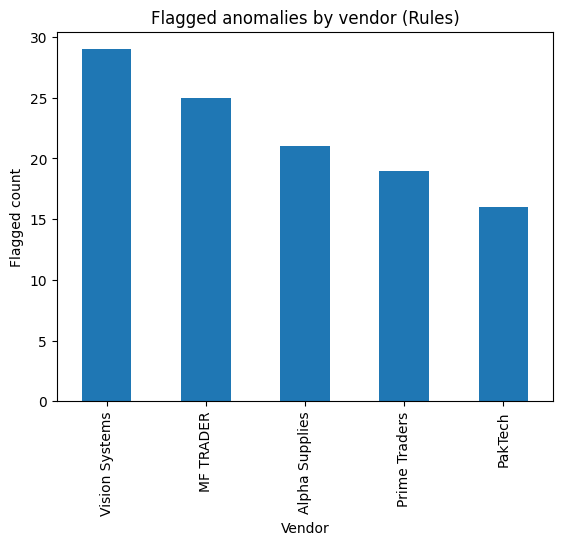

In [34]:
import matplotlib.pyplot as plt

vendor_flags = (df[df["pred_anomaly_rules"]==1]
                .groupby("vendor")["pred_anomaly_rules"]
                .count()
                .sort_values(ascending=False))

vendor_flags.plot(kind="bar")
plt.title("Flagged anomalies by vendor (Rules)")
plt.xlabel("Vendor")
plt.ylabel("Flagged count")
plt.show()


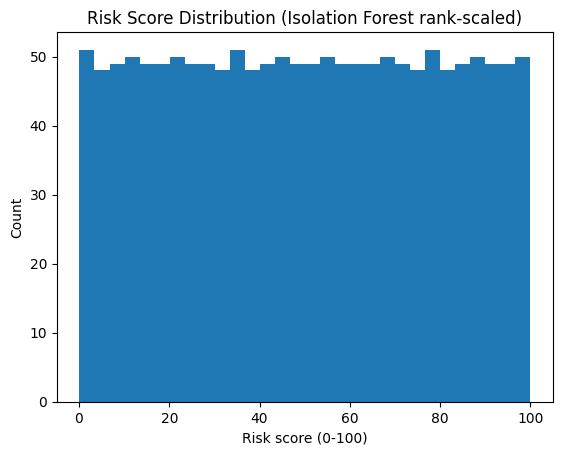

In [35]:
df["risk_score_rank"].plot(kind="hist", bins=30)
plt.title("Risk Score Distribution (Isolation Forest rank-scaled)")
plt.xlabel("Risk score (0-100)")
plt.ylabel("Count")
plt.show()


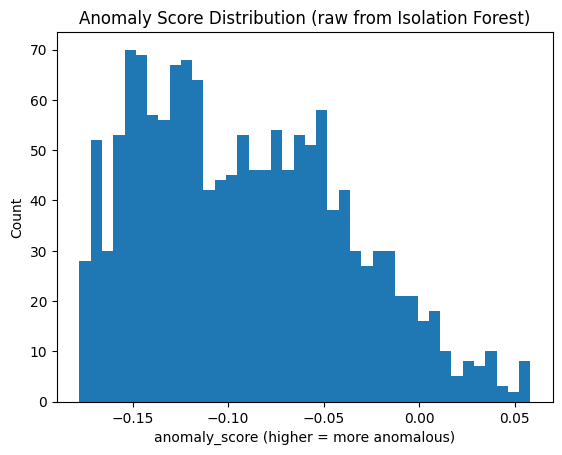

In [36]:
import matplotlib.pyplot as plt

df["anomaly_score"].plot(kind="hist", bins=40)
plt.title("Anomaly Score Distribution (raw from Isolation Forest)")
plt.xlabel("anomaly_score (higher = more anomalous)")
plt.ylabel("Count")
plt.show()


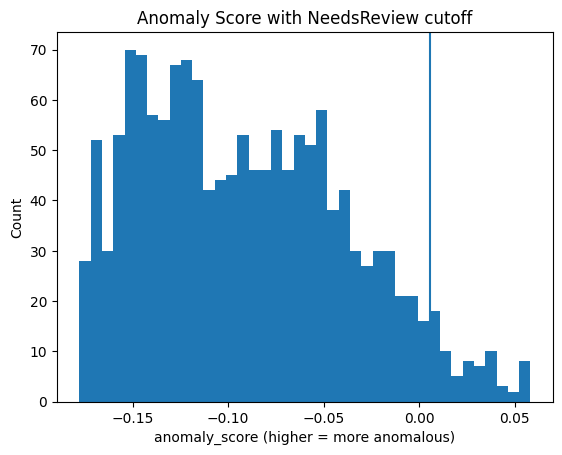

NeedsReview anomaly_score cutoff: 0.005777007955477975


In [37]:
cutoff = df.loc[df["needs_review"]==1, "anomaly_score"].min()

df["anomaly_score"].plot(kind="hist", bins=40)
plt.axvline(cutoff)
plt.title("Anomaly Score with NeedsReview cutoff")
plt.xlabel("anomaly_score (higher = more anomalous)")
plt.ylabel("Count")
plt.show()

print("NeedsReview anomaly_score cutoff:", cutoff)


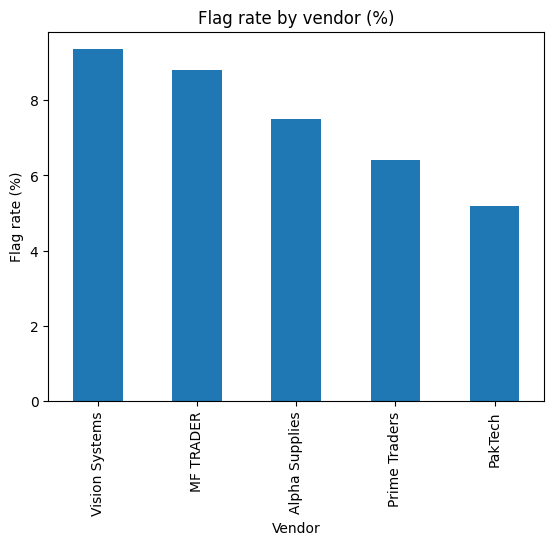

,total_rows,flagged,needs_review,flag_rate
vendor,,,,
Vision Systems,310,29,9,9.354839
MF TRADER,284,25,5,8.802817
Alpha Supplies,280,21,1,7.500000
Prime Traders,296,19,4,6.418919
PakTech,308,16,2,5.194805


In [38]:
import pandas as pd
import matplotlib.pyplot as plt

vendor_stats = df.groupby("vendor").agg(
    total_rows=("doc_id","count"),
    flagged=("pred_anomaly_rules","sum"),
    needs_review=("needs_review","sum")
)

vendor_stats["flag_rate"] = (vendor_stats["flagged"] / vendor_stats["total_rows"]) * 100
vendor_stats = vendor_stats.sort_values("flag_rate", ascending=False)

vendor_stats["flag_rate"].plot(kind="bar")
plt.title("Flag rate by vendor (%)")
plt.xlabel("Vendor")
plt.ylabel("Flag rate (%)")
plt.show()

vendor_stats


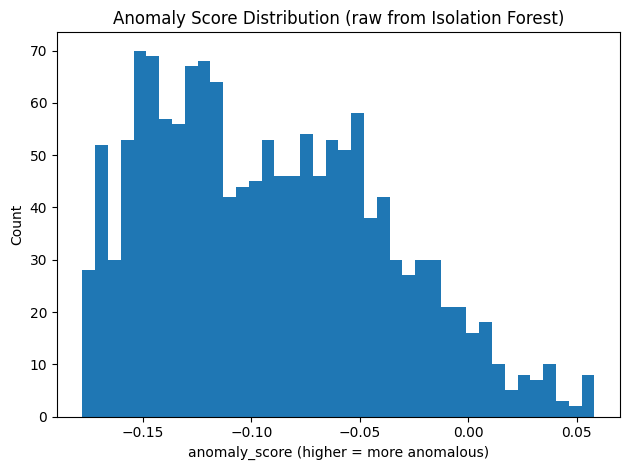

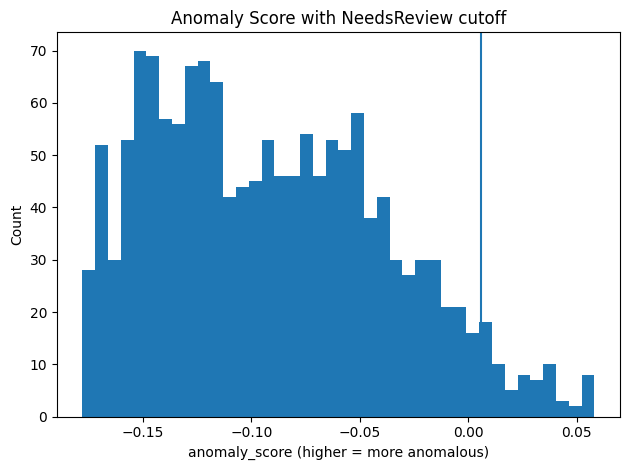

AttributeError: module 'matplotlib.pyplot' has no attribute 'sho'

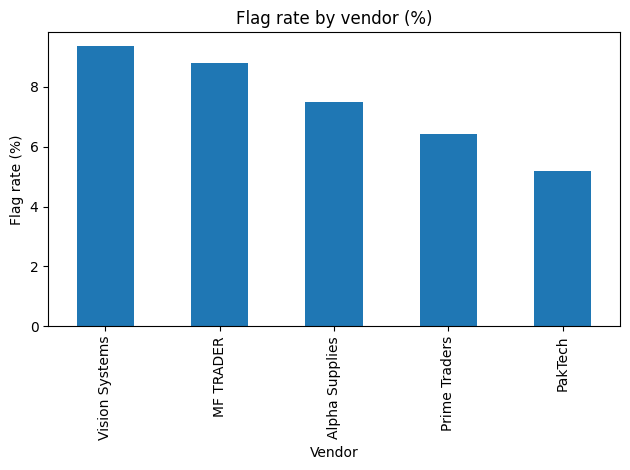

In [39]:
import matplotlib.pyplot as plt

# 1) Anomaly score distribution
plt.figure()
df["anomaly_score"].plot(kind="hist", bins=40)
plt.title("Anomaly Score Distribution (raw from Isolation Forest)")
plt.xlabel("anomaly_score (higher = more anomalous)")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("anomaly_score_dist.png", dpi=200)
plt.show()

# 2) Cutoff chart
cutoff = df.loc[df["needs_review"]==1, "anomaly_score"].min()

plt.figure()
df["anomaly_score"].plot(kind="hist", bins=40)
plt.axvline(cutoff)
plt.title("Anomaly Score with NeedsReview cutoff")
plt.xlabel("anomaly_score (higher = more anomalous)")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("needs_review_cutoff.png", dpi=200)
plt.show()

# 3) Flag rate by vendor
plt.figure()
vendor_stats["flag_rate"].plot(kind="bar")
plt.title("Flag rate by vendor (%)")
plt.xlabel("Vendor")
plt.ylabel("Flag rate (%)")
plt.tight_layout()
plt.savefig("flag_rate_by_vendor.png", dpi=200)
plt.sho


In [41]:
import os
os.path.exists("invoice_anomaly_scored_output.csv")


True

In [42]:
!ls -lh


total 540K
-rw-r--r-- 1 root root  48K Jan 14 08:41 anomaly_score_dist.png
-rw-r--r-- 1 root root  48K Jan 14 08:41 flag_rate_by_vendor.png
-rw-r--r-- 1 root root 206K Jan 14 08:36 invoice_anomaly_scored_output.csv
-rw-r--r-- 1 root root 182K Jan 14 07:47 invoice_quotes_clean_v1.csv
-rw-r--r-- 1 root root  47K Jan 14 08:41 needs_review_cutoff.png
drwxr-xr-x 1 root root 4.0K Dec 11 14:34 sample_data


In [43]:
from google.colab import files
files.download("invoice_anomaly_scored_output.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>